MCMC (Markov Chain Monte Carlo)
--

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
from gpflow.test_util import notebook_niter
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

## Introduction to HMC

GPflow allows you to approximate the posterior over the latent functions of its models (and hyperparemeter after setting a prior for those) using Hamiltonian Monte Carlo (HMC)

## Example 1: GP Regression

We first consider the GP regression (with Gaussian noise) for which the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

See the [GPR notebook](../basics/regression.ipynb) for a treatment of the direct likelihood optimization.

#### Data for a 1-dimensional regression problem

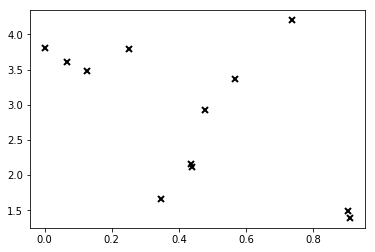

In [2]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)

#### MCMC for hyperparameters $\theta$

We now want to sample from $p(\theta|\mathbf{y}) \propto p(\mathbf{y}|\theta)p(\theta)$

First, we build the GPR model

In [3]:
gpflow.reset_default_graph_and_session()
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

Second, we initialize the model to the maximum likelihood solution.

In [4]:
gpflow.train.ScipyOptimizer().minimize(m)
print('log likelihood:', m.compute_log_likelihood())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 9.207056
  Number of iterations: 20
  Number of functions evaluations: 21


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 9.207056
  Number of iterations: 20
  Number of functions evaluations: 21


log likelihood: -9.207056081081365


Third, we add priors to the hyperparameters

In [5]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.08883191452997337
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.9048426794358455
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.0020465690186956442
GPR/mean_function/A,Parameter,"N(0.0,10.0)",(none),True,"(1, 1)",True,[[-1.6657497593352397]]
GPR/mean_function/b,Parameter,"N(0.0,10.0)",(none),True,(),True,3.7764580541470387


We now sample the posterior using HMC

In [6]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=gpflow.test_util.notebook_niter(500),
                         epsilon=0.05, lmin=10, lmax=20, logprobs=False)

Text(0, 0.5, 'parameter value')

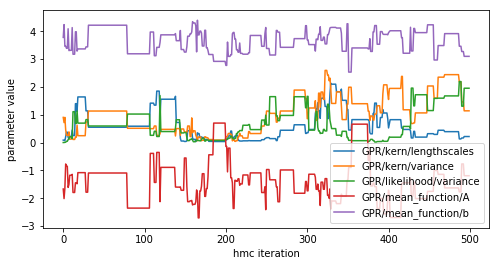

In [7]:
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')



Note that the sampler runs in unconstrained space (so that positive parameters remain positive, parameters that are not trainable are ignored), but GPflow returns a dataframe with values in the true units.

For serious analysis you most certainly want to run the sampler longer, with multiple chains and convergence checks. This will do for illustration though!


Text(0, 0.5, 'signal_variance')

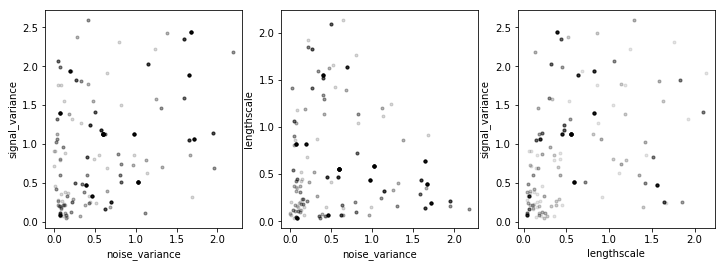

In [8]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(samples['GPR/kern/lengthscales'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each sample. Then, for that state (set of hyper-parameters) we'll draw some samples from the prediction function.

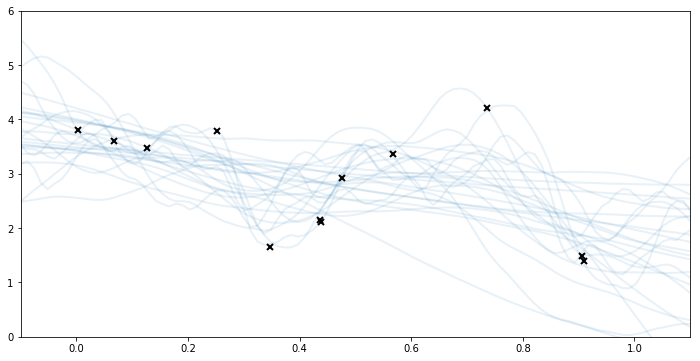

In [9]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)
    
plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)


## Example 2: Sparse MC for Multiclass Classification

We now consider the multiclass classification problem (see the [Multiclass notebook](../advanced/multiclass.ipynb)). Here the marginal likelihood is not available in closed form. Instead we use a sparse variational approximation where we approximate the posterior for each GP as $q(f_c) \propto p(f_c|\mathbf{u}_c)q(\mathbf{u}_c)$

In the standard SVGP formulation, $q(\mathbf{u_c})$ is parameterized as a multivariate Gaussian.

An alternative is to directly sample from the optimal $q(\mathbf{u}_c)$; this is what the SGPMC does. 

In [28]:
gpflow.reset_default_graph_and_session()
from gpflow.test_util import notebook_niter, is_continuous_integration

We first build a multiclass classification dataset

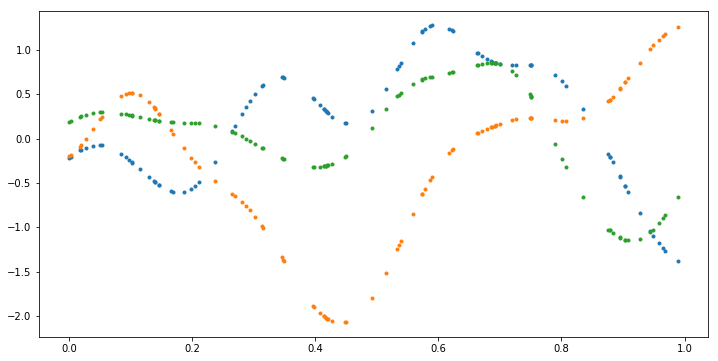

In [29]:
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)
plt.figure(figsize=(12,6))
plt.plot(X, f, '.');

We then build the SGPMC model

In [30]:
with gpflow.defer_build():
    m = gpflow.models.SGPMC(X, Y, 
                     kern=gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01),
                     likelihood=gpflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)
    m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(2., 2.)
    m.kern.kernels[1].variance.trainables = False
    
m.compile()

The chain of samples for $\mathbf{u}_c$ is initialized at the value maximizing  $p(Y|\mathbf{u}_c$)

In [31]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=notebook_niter(10))

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 153.863351
  Number of iterations: 10
  Number of functions evaluations: 12


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 153.863351
  Number of iterations: 10
  Number of functions evaluations: 12


Sampling starts with a 'burn in' period

In [32]:
if is_continuous_integration():
    burn = 0
    thin = 1
else:
    burn = 100
    thin = 10

In [34]:
hmc = gpflow.train.HMC()
samples = hmc.sample(m, num_samples=notebook_niter(500), 
                     epsilon=0.04, lmax=15, logprobs=False)

Statistics of the posterior samples can now be reported

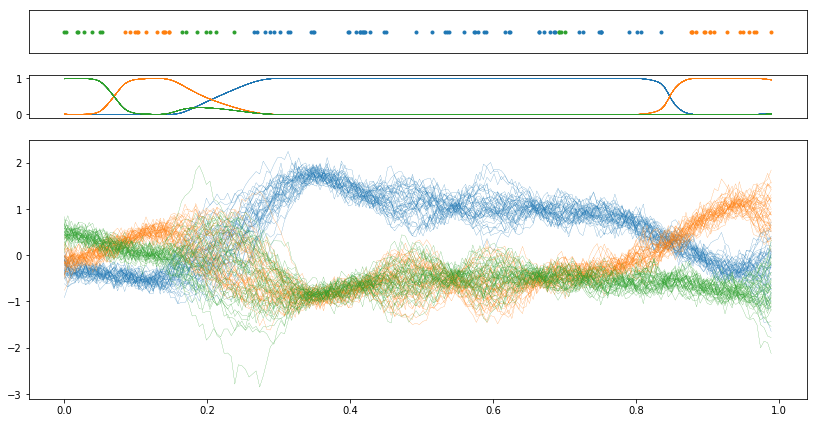

In [35]:
def plot_from_samples(m, samples):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    
    Fpred, Ypred = [], []

    for i, s in samples[burn::thin].iterrows():  # also possible as arguments to hmc.sample()
        feed_dict = m.sample_feed_dict(s)
        Ypred.append(m.predict_y(xx, feed_dict=feed_dict)[0])
        Fpred.append(m.predict_f_samples(xx, 1, feed_dict=feed_dict).squeeze())

    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten() == i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

plot_from_samples(m, samples)

In [36]:
samples.head()

,SGPMC/V,SGPMC/feature/Z,SGPMC/kern/kernels/0/lengthscales,SGPMC/kern/kernels/0/variance,SGPMC/kern/kernels/1/variance
0,"[[1.7180023501788932, -0.8858712919664435, -0....","[[0.3424142148534031], [0.12116941572307079], ...",0.120188,1.014961,0.009599
1,"[[1.7180023501788932, -0.8858712919664435, -0....","[[0.3424142148534031], [0.12116941572307079], ...",0.120188,1.014961,0.009599
2,"[[1.7180023501788932, -0.8858712919664435, -0....","[[0.3424142148534031], [0.12116941572307079], ...",0.120188,1.014961,0.009599
3,"[[1.7180023501788932, -0.8858712919664435, -0....","[[0.3424142148534031], [0.12116941572307079], ...",0.120188,1.014961,0.009599
4,"[[1.7180023501788932, -0.8858712919664435, -0....","[[0.3424142148534031], [0.12116941572307079], ...",0.120188,1.014961,0.009599


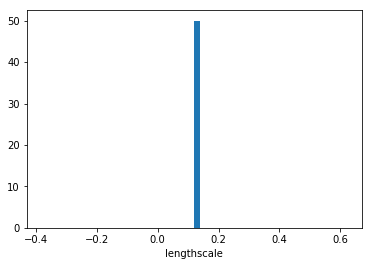

In [37]:
plt.hist(np.vstack(samples['SGPMC/kern/kernels/0/lengthscales']).flatten(), 50, density=True)
plt.xlabel('lengthscale');

Fully Bayesian inference for generalized GP models with HMC
--

*James Hensman, 2015, 2016, 2017*

It's possible to construct a very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable since the likelihoods is not generally conjugate to the Gaussian process. The general form of the model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta))\\y_i \sim p(y | g(f(x_i))\,.$$


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function-values and the parameters $\theta$ jointly. Key to an effective scheme is rotation of the field using the Cholesky decomposition. We write

$$\theta \sim p(\theta)\\v \sim \mathcal {N}(0,\, I)\\LL^\top = K\\f = m + Lv\\y_i \sim p(y | g(f(x_i))\,.$$

Joint HMC over v and the function values is not widely adopted in the literature becate of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in tensorflow, and so application of HMC is relatively straightforward. 

### Exponential Regression example
The first illustration in this notebook is 'Exponential Regression'. The model is 
$$\theta \sim p(\theta)\\f \sim \mathcal {GP}(0, k(x, x'; \theta))\\f_i = f(x_i)\\y_i \sim \mathcal {Exp} (e^{f_i})$$

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. first, generate a data set.

In [19]:


X = np.linspace(-3,3,20)
Y = np.random.exponential(np.sin(X)**2)

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function. 

In [20]:
gpflow.reset_default_graph_and_session()


with gpflow.defer_build():
    k = gpflow.kernels.Matern32(1, ARD=False) + gpflow.kernels.Bias(1)
    l = gpflow.likelihoods.Exponential()
    m = gpflow.models.GPMC(X[:,None], Y[:,None], k, l)

The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration). 

In [21]:
m.kern.kernels[0].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.kernels[0].variance.prior = gpflow.priors.Gamma(1., 1.)
m.kern.kernels[1].variance.prior = gpflow.priors.Gamma(1., 1.)

Running HMC is pretty similar to optimizing a model. GPflow only has HMC sampling for the moment, and it's a relatively vanilla implementation (no NUTS, for example). There are two things to tune, the step size (epsilon) and the number of steps [Lmin, Lmax]. Each proposal will take a random number of steps between Lmin and Lmax, each of length epsilon. 

We'll use the `verbose` setting so that we can see the acceptance rate. <- this is broken :(

In [22]:
m.compile()
o = gpflow.train.AdamOptimizer(0.01)
o.minimize(m, maxiter=notebook_niter(15)) # start near MAP

In [23]:
s = gpflow.train.HMC()
samples = s.sample(m, notebook_niter(500),
                   epsilon=0.12, lmax=20, lmin=5, thin=5, logprobs=False)#, verbose=True)

In [24]:
xtest = np.linspace(-4,4,100)[:,None]
f_samples = []
for i, s in samples.iterrows():
    f = m.predict_f_samples(xtest, 5, initialize=False, feed_dict=m.sample_feed_dict(s))
    f_samples.append(f)
f_samples = np.vstack(f_samples)

(-0.1, 7.268856165399205)

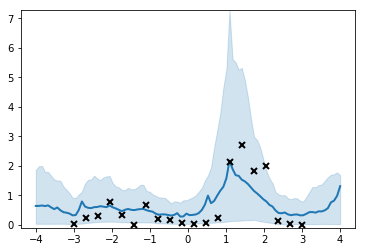

In [25]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))

In [26]:
samples.head()

,GPMC/V,GPMC/kern/kernels/0/lengthscales,GPMC/kern/kernels/0/variance,GPMC/kern/kernels/1/variance
0,"[[-1.4583690101570275], [0.4137859901289479], ...",1.370391,0.396731,0.355152
1,"[[-1.5697603272964447], [1.5822793977528962], ...",0.722981,0.241198,0.361054
2,"[[-0.7826557416825409], [-0.020470147065259514...",1.403380,0.260579,1.262918
3,"[[-1.8625289637996394], [2.0374414887301096], ...",0.391410,0.302829,0.286904
4,"[[-1.8625289637996394], [2.0374414887301096], ...",0.391410,0.302829,0.286904


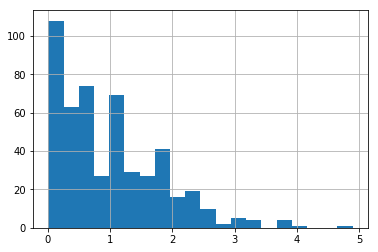

In [27]:
samples['GPMC/kern/kernels/0/variance'].hist(bins=20)